Firstly, we will make sure to import every library that we will further use in this project.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Now we are going to read the data set.

In [5]:
ds = pd.read_csv("MergeConflictsDataset.csv", sep=";")
ds.describe()

,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
count,26973.000000,2.697300e+04,2.697300e+04,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,...,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000
mean,0.777741,4.255746e+02,2.504278e+02,4.656175,1.911801,240.714159,0.752048,2.431061,1.396545,0.970229,...,4.316205,0.955437,1.338857,0.096281,1.007860,51.391280,104.662551,69.455646,68.021095,0.054425
std,0.415772,8.887706e+03,1.027916e+04,12.230444,6.534316,908.382038,10.620490,67.840678,90.614277,64.245155,...,12.924317,3.203307,4.269666,0.541916,6.033535,34.560112,89.471017,40.057823,39.385369,0.226858
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000e+00,1.000000e+00,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,47.000000,41.000000,40.000000,0.000000
50%,1.000000,1.100000e+01,2.000000e+00,1.000000,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,46.000000,88.000000,66.391304,65.000000,0.000000
75%,1.000000,7.500000e+01,1.500000e+01,3.000000,1.000000,139.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,67.000000,131.000000,91.714286,90.000000,0.000000
max,1.000000,1.140945e+06,1.140456e+06,158.000000,182.000000,21513.000000,1152.000000,10404.000000,10396.000000,10398.000000,...,176.000000,48.000000,78.000000,16.000000,312.000000,1326.000000,1326.000000,1326.000000,1326.000000,1.000000


As a starting point for every Machine Learning project we want to generate a Correlation Matrix.

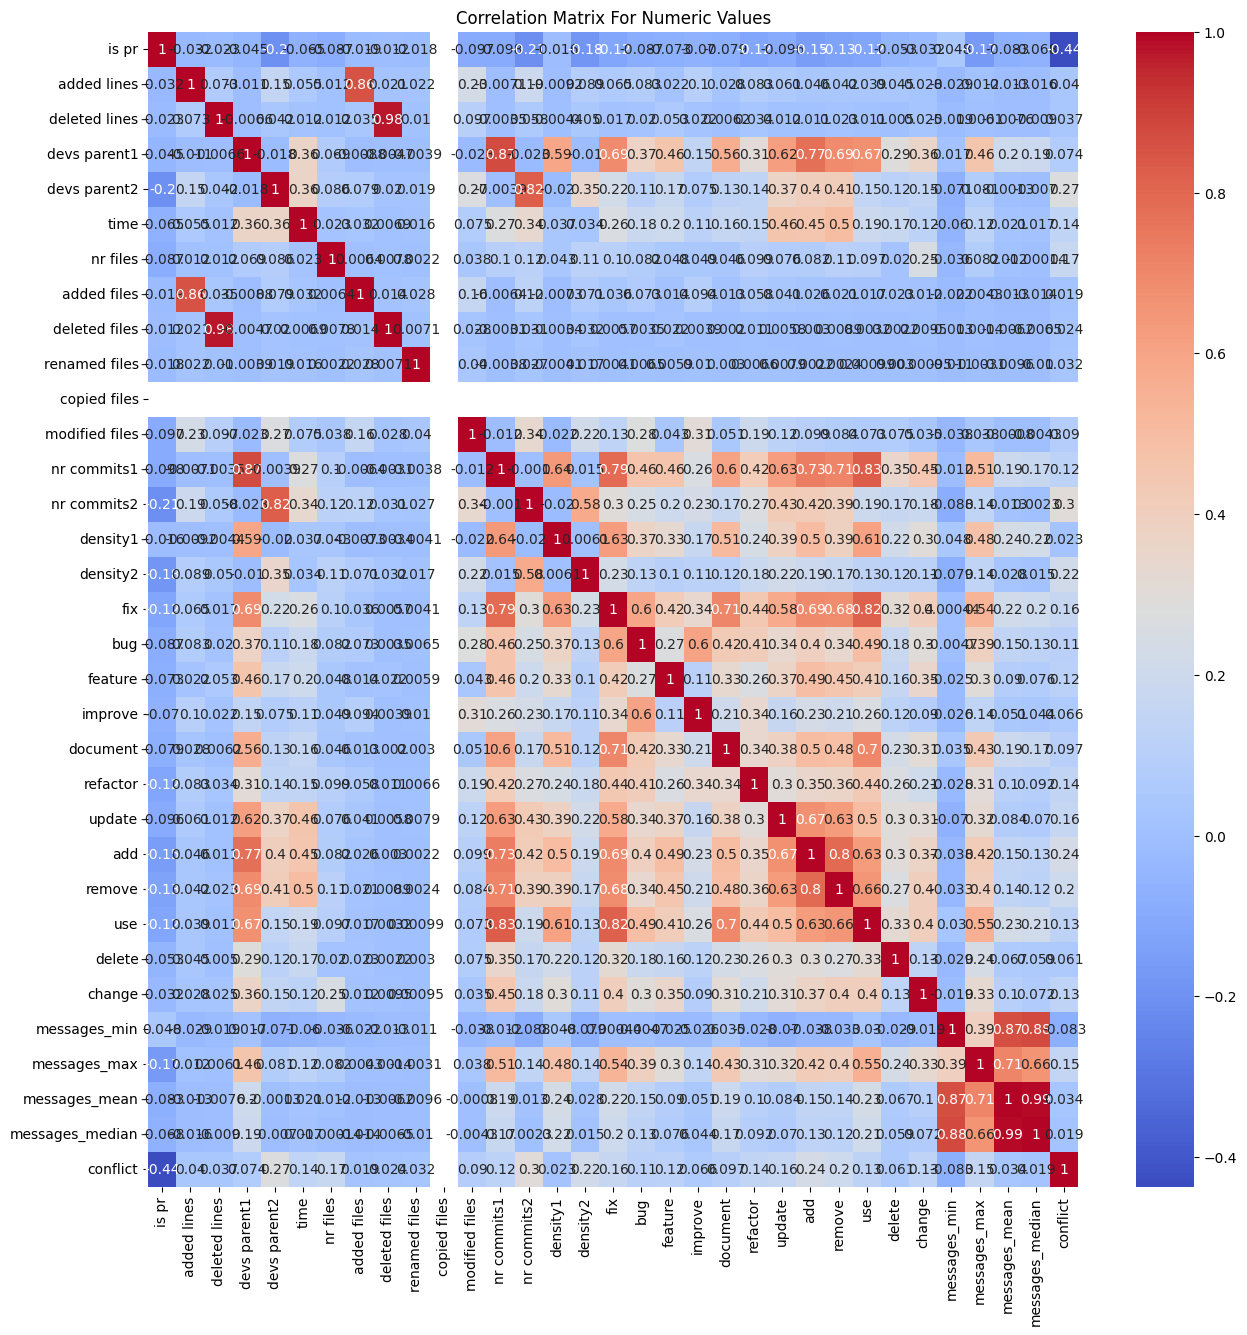

In [6]:
numeric_columns = ds.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix For Numeric Values")
plt.show()

We are checking now if the data is empty.

In [7]:
print(ds.isna().sum())

commit             0
parent1            0
parent2            0
ancestor           1
is pr              0
added lines        0
deleted lines      0
devs parent1       0
devs parent2       0
time               0
nr files           0
added files        0
deleted files      0
renamed files      0
copied files       0
modified files     0
nr commits1        0
nr commits2        0
density1           0
density2           0
fix                0
bug                0
feature            0
improve            0
document           0
refactor           0
update             0
add                0
remove             0
use                0
delete             0
change             0
messages_min       0
messages_max       0
messages_mean      0
messages_median    0
conflict           0
dtype: int64


We observe that there is one field for ancestor which contains NaN values. However since this column is not explicitly used for making assumption we don't need to provide a value for it. As we will get rid of it into the future.

Since some values are predictable we want to generate some histograms which will lead us to undestand more about the provided dataset.
For example we can record how many conflicts or how many PRs there are. However since this project's main goal is to train a model to find out the conflicts we will record only the variables which are in strong relation with the conflicts.

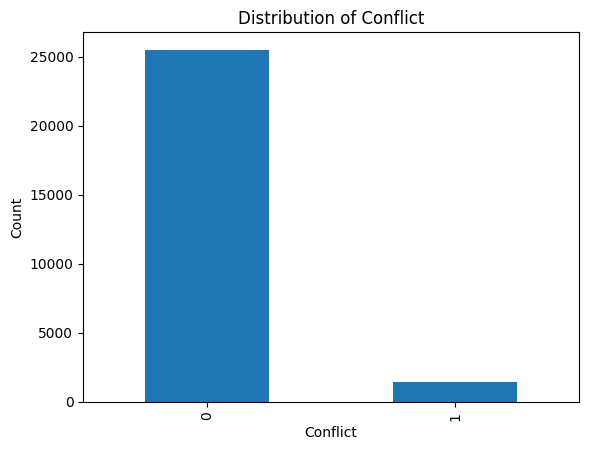

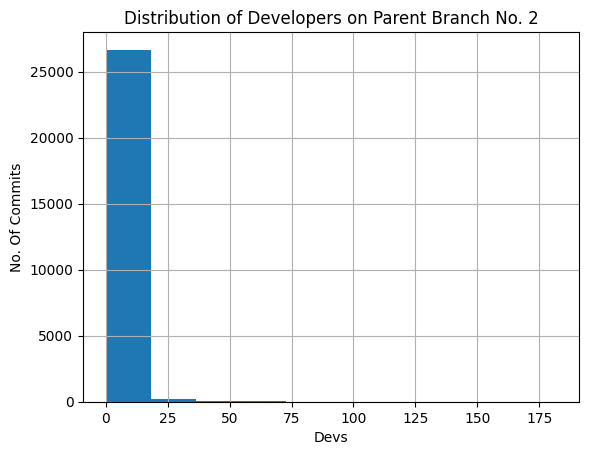

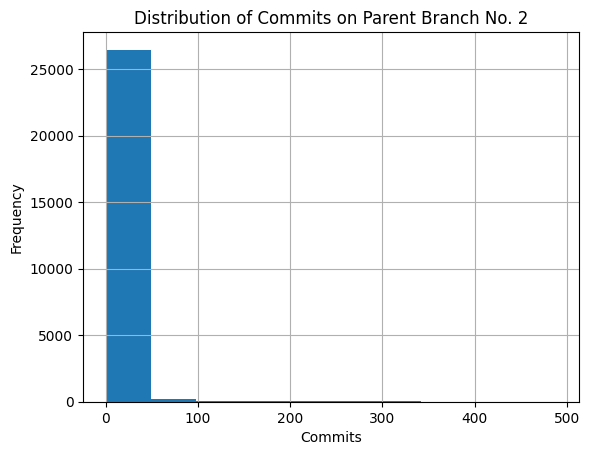

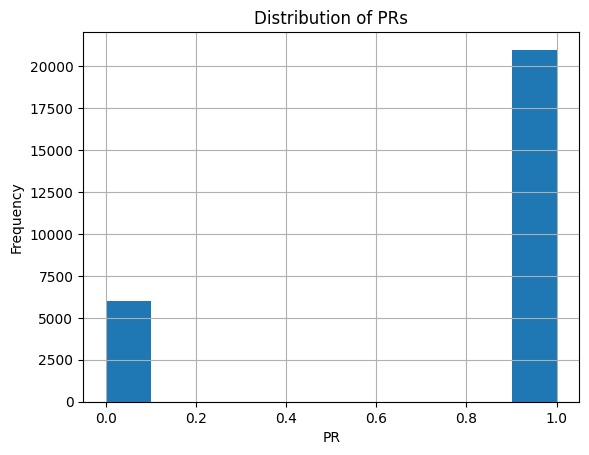

In [19]:
ds['conflict'].value_counts().plot(kind='bar')
plt.title('Distribution of Conflict')
plt.xlabel('Conflict')
plt.ylabel('Count')
plt.show()

ds['devs parent2'].hist()
plt.title('Distribution of Developers on Parent Branch No. 2')
plt.ylabel('No. Of Commits')
plt.xlabel('Devs')
plt.show()

ds['nr commits2'].hist()
plt.title('Distribution of Commits on Parent Branch No. 2')
plt.ylabel('Frequency')
plt.xlabel('Commits')
plt.show()

ds['is pr'].hist()
plt.title('Distribution of PRs')
plt.ylabel('Frequency')
plt.xlabel('PR')
plt.show()

Let's set aside the test data set for now.

This is one of the first things we should do, as we want to test our final model on unseen/unbiased data.

In [70]:
y = ds['conflict']
x = ds.drop(['commit', 'parent1', 'parent2', 'ancestor', 'conflict'], axis=1)


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Next, we will choose 6 classifiers, for which we will provide the testing data.

In [71]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier 

Now that we have imported our models we will use them for training.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters.

Logistic Regression is a machine learning algorithm that allows us to create a classification model. The algorithm analyses one/more independent variables and one dependent variable, to predict the output. This algorithm is used to predict categorical variables using independent variables which are continuous.

C-Support Vector Classiffication.

KNeighborClassifier implementing the k-nearest neighbors vote.

In [72]:
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
    ('MLPClassifier', MLPClassifier(max_iter=1000)),
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('SVC', SVC()),
    ('KNeighbourClassifier', KNeighborsClassifier(5))
]


Once we have built a classification model, we need evaluate how good the predictions made by that model are. 

Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

F1-score: This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.

We use the Harmonic Mean since it penalizes the extreme values.

To summarise the differences between the F1-score and the accuracy,

Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial
Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.
In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our

/home/stefan_jiroveanu/anaconda3/envs/stefanj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan_jiroveanu/anaconda3/envs/stefanj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan_jiroveanu/anaconda3/envs/stefanj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

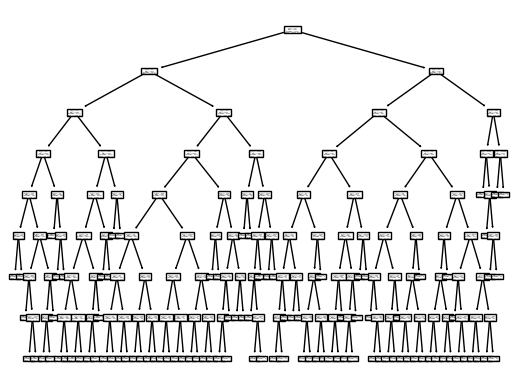

In [78]:
scores = []
reports = []

for model in models:
    model[1].fit(x_train, y_train)
    y_train_after_prediction = model[1].predict(x_train)
    y_test_after_prediction = model[1].predict(x_test)

    train_accuracy = accuracy_score(y_train_after_prediction, y_train)
    train_f1score = f1_score(y_train, y_train_after_prediction)
    test_accuracy = accuracy_score(y_test, y_test_after_prediction)
    test_f1score = f1_score(y_test, y_test_after_prediction)
    mean_abs_error = mean_absolute_error(y_test, y_test_after_prediction)
    clreport = classification_report(y_test, y_test_after_prediction)
    cm = confusion_matrix(y_test, y_test_after_prediction)

    scores.append((model[0], train_accuracy, train_f1score, test_accuracy, test_f1score))
    reports.append((model[0], mean_abs_error, clreport, cm, test_accuracy))

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'gini', max_depth=8, min_samples_leaf = 5, min_samples_split = 2, splitter = 'best')
clf.fit(x_train, y_train)
from sklearn import tree
tree.plot_tree(clf)
y_train_after_prediction = model[1].predict(x_train)
y_test_after_prediction = model[1].predict(x_test)

train_accuracy = accuracy_score(y_train_after_prediction, y_train)
train_f1score = f1_score(y_train, y_train_after_prediction)
test_accuracy = accuracy_score(y_test, y_test_after_prediction)
test_f1score = f1_score(y_test, y_test_after_prediction)
mean_abs_error = mean_absolute_error(y_test, y_test_after_prediction)
clreport = classification_report(y_test, y_test_after_prediction)
cm = confusion_matrix(y_test, y_test_after_prediction)

scores.insert(0, ('Decision Tree Classifier', train_accuracy, train_f1score, test_accuracy, test_f1score))
reports.insert(0,('Decision Tree Classifier', mean_abs_error, clreport, cm, test_accuracy))



Now we are foing to create a DataFrame for each score object, and represent the data.

Eroare : 0.051714550509731234

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5090
           1       0.64      0.19      0.29       305

    accuracy                           0.95      5395
   macro avg       0.80      0.59      0.63      5395
weighted avg       0.94      0.95      0.93      5395


Accuracy:  0.9482854494902687


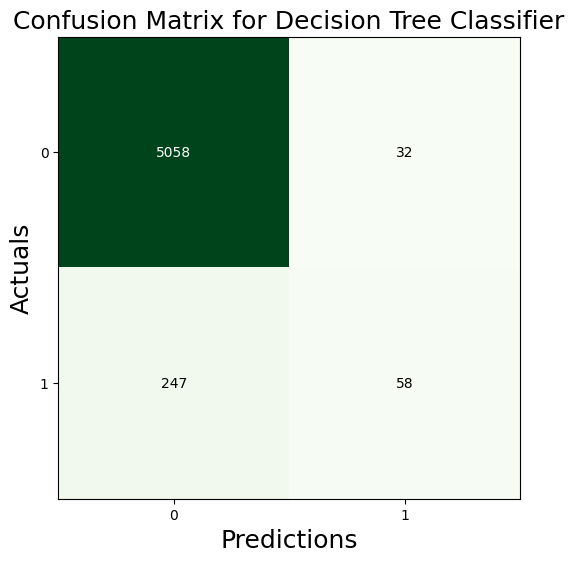

Eroare : 0.03151065801668211

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      5090
           1       0.80      0.59      0.68       305

    accuracy                           0.97      5395
   macro avg       0.89      0.79      0.83      5395
weighted avg       0.97      0.97      0.97      5395


Accuracy:  0.9684893419833179


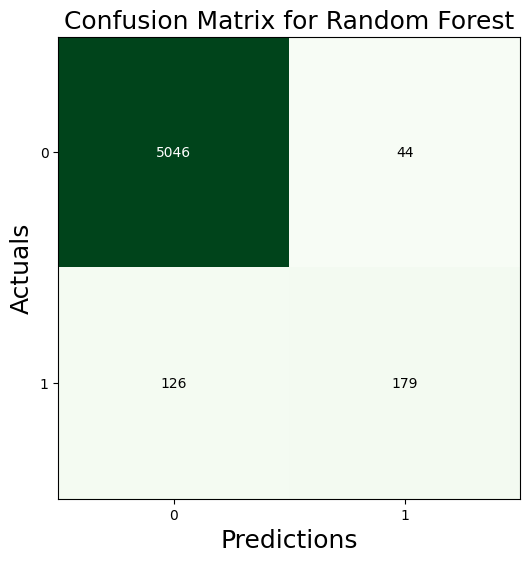

Eroare : 0.05356811862835959

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5090
           1       0.53      0.50      0.51       305

    accuracy                           0.95      5395
   macro avg       0.75      0.73      0.74      5395
weighted avg       0.94      0.95      0.95      5395


Accuracy:  0.9464318813716404


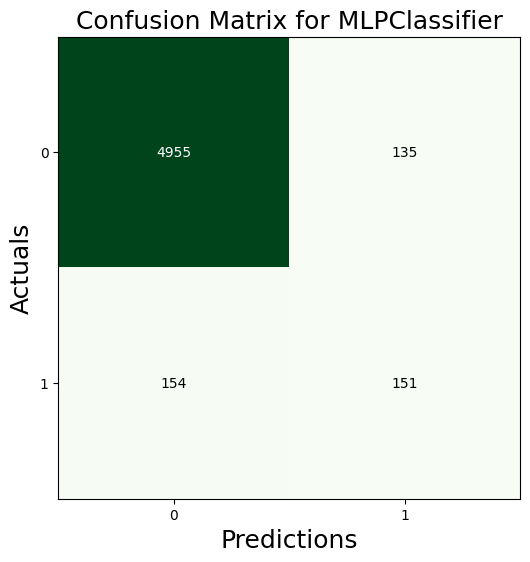

Eroare : 0.043373493975903614

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      5090
           1       0.76      0.34      0.47       305

    accuracy                           0.96      5395
   macro avg       0.86      0.67      0.72      5395
weighted avg       0.95      0.96      0.95      5395


Accuracy:  0.9566265060240964


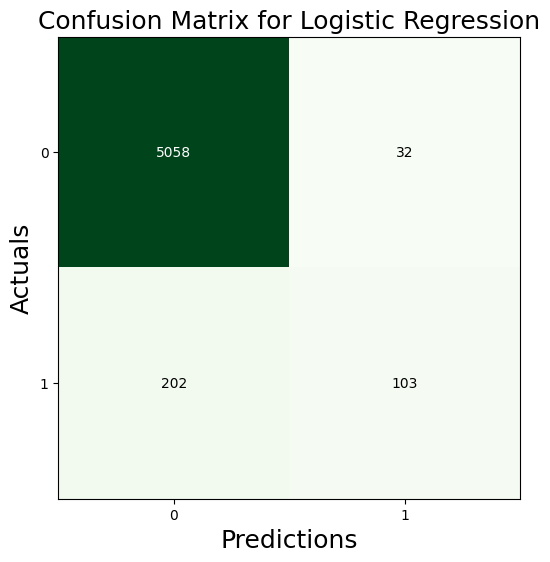

Eroare : 0.056533827618164965

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5090
           1       0.00      0.00      0.00       305

    accuracy                           0.94      5395
   macro avg       0.47      0.50      0.49      5395
weighted avg       0.89      0.94      0.92      5395


Accuracy:  0.943466172381835


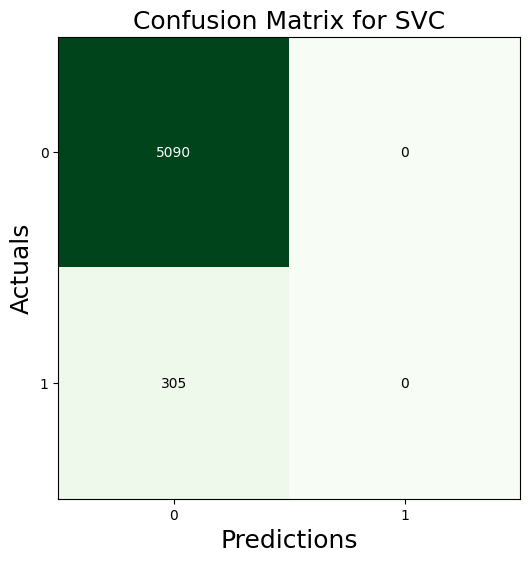

Eroare : 0.051714550509731234

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5090
           1       0.64      0.19      0.29       305

    accuracy                           0.95      5395
   macro avg       0.80      0.59      0.63      5395
weighted avg       0.94      0.95      0.93      5395


Accuracy:  0.9482854494902687


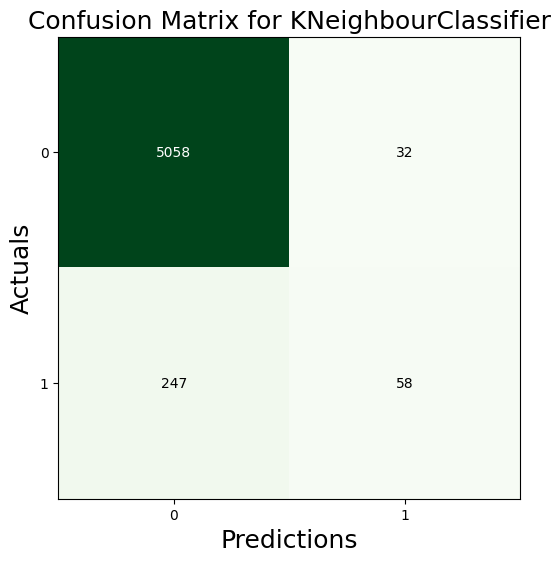

                      Model  Training Accuracy  Training F1 Score  \
0  Decision Tree Classifier           0.955927           0.400756   
1             Random Forest           1.000000           1.000000   
2             MLPClassifier           0.955093           0.564494   
3       Logistic Regression           0.958940           0.461725   
4                       SVC           0.946473           0.013664   
5      KNeighbourClassifier           0.955927           0.400756   

   Test Accuracy  Test F1 Score  
0       0.948285       0.293671  
1       0.968489       0.678030  
2       0.946432       0.510998  
3       0.956627       0.468182  
4       0.943466       0.000000  
5       0.948285       0.293671  


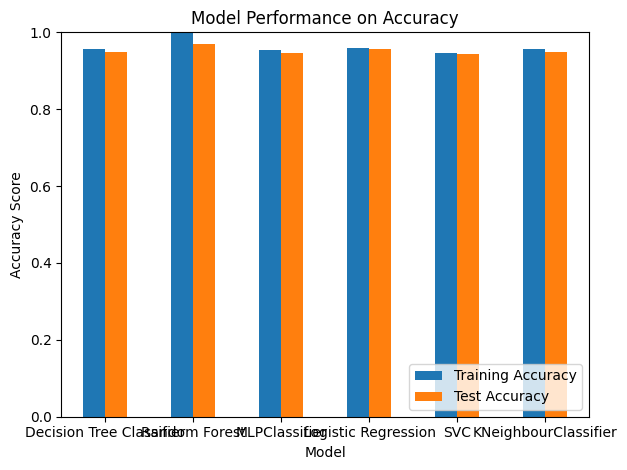

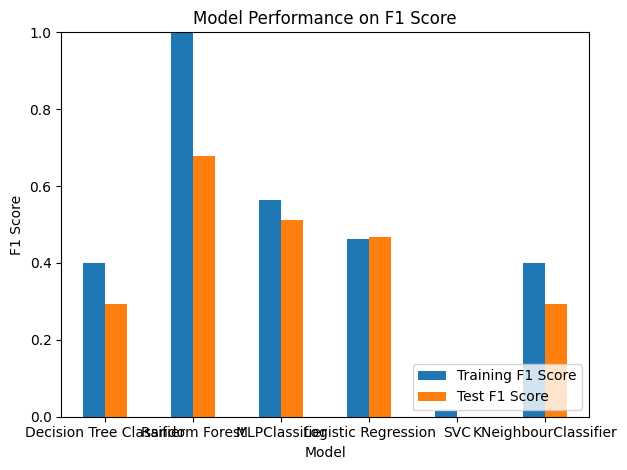

In [79]:
for report in reports :
    print('Eroare :', report[1])
    print('\nClassification report:\n', report[2])
    print('\nAccuracy: ', report[4])
    fig, ax = plot_confusion_matrix(conf_mat=report[3], figsize=(6, 6), cmap=plt.cm.Greens)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    name = 'Confusion Matrix for ' + report[0]
    plt.title(name, fontsize=18)
    plt.show()


scores = pd.DataFrame(scores, columns=['Model', 'Training Accuracy', 'Training F1 Score', 'Test Accuracy', 'Test F1 Score'])

print(scores)

scores.set_index('Model')[['Training Accuracy', 'Test Accuracy']].plot(kind='bar', rot=0)
plt.title('Model Performance on Accuracy')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

scores.set_index('Model')[['Training F1 Score', 'Test F1 Score']].plot(kind='bar', rot=0)
plt.title('Model Performance on F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Add the advantages and disadvantages of Accuracy(are they relevant)

What happens if we make the precision bigger.